In [9]:
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import binom
from numba import njit, prange

In [10]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [11]:
sns.set_palette("colorblind")

## Problem setup
We consider the price process given by
$$
\begin{aligned}
    S_{t+\Delta} &= S_{t} + m_{t+\Delta}\Delta + \sigma\sqrt{\Delta}B(a_t),\\
    m_{t+\Delta} &= \kappa\,m_t + \sigma_m\sqrt{\Delta}B(p_m).
\end{aligned}
$$
The inventory process $Q_t$ and the cash process $X_t$ are given by
$$
\begin{aligned}
    Q_{t+\Delta} &= Q_t + a_t\\
    X_{t+\Delta} &= X_{t+\Delta} - a_t\,(S_t + \kappa a_t)
\end{aligned}
$$
with 
* $B(a_t) \sim \mathrm{Bern}(\sigma(b\,a_t))$,
* $B(p_m) \sim \mathrm{Bern}(p_m)$,
* $p_m \in (0,1)$,
* $\kappa > 0$ a mean-reverting factor.
* $a_t\in \{a_\text{min}, a_\text{min} + 1, \ldots, a_\text{max} - 1, a_\text{max}\}$ action at time $t$.

The return at time $T$ is given by
$$
    G_T = X_T + Q_T\,S_T - \alpha\,Q_T^2.
$$
Then, the reward at time $t$ is given by
$$
    r_t = G_{t} - G_{t-1} =
    (Q_t + a_t)\, B(a_t) - (\kappa + \alpha)\,a^2_t - 2\,\alpha\,Q_t\,a_t + (Q_t + a_t)(\hat\kappa\,m_t + B(p_m)).
$$


To solve the problem in tabular form, we clip $S_t$ to a maximum and minimum value.

In [12]:
MAX_PRICE = 20 # price in [0, MAX_PRICE]
MAX_INVENTORY = 50 # max inventory per side
MAX_CASH = 50 # max cash per side
MAX_ACTION = 20 # max buy and sell
DISCOUNT = 0.9
MAX_SIGNAL = 5 # max value of signal per side

In [13]:
np.set_printoptions(linewidth=120, precision=4)

In [173]:
n_bins_signal = 50
n_bins_price = 30
bins_signal = np.linspace(-MAX_SIGNAL, MAX_SIGNAL, n_bins_signal)
bins_price = np.linspace(0, MAX_PRICE, n_bins_price)

lattice_price = (bins_signal[None, :] + bins_price[:, None])


# lattice_price[np.where((lattice_price < 0) | (lattice_price > MAX_PRICE))] = np.nan
lattice_price[np.where(lattice_price < 0)] = 0.0
lattice_price[np.where(lattice_price > MAX_PRICE)] = MAX_PRICE

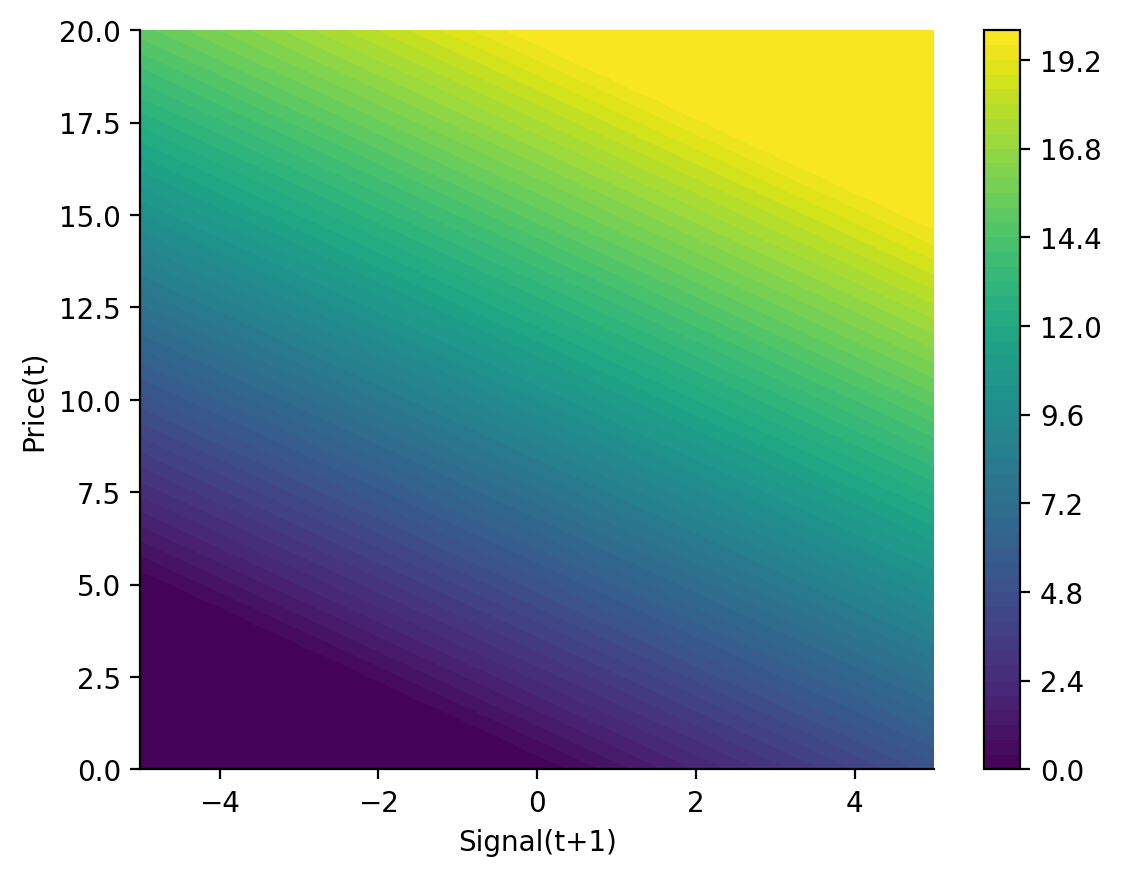

In [174]:
plt.contourf(bins_signal, bins_price, lattice_price, levels=50)
plt.ylabel("Price(t)")
plt.xlabel("Signal(t+1)")
plt.colorbar()

In [175]:
force_signal = 2
np.random.multinomial(1, np.ones(force_signal) / force_signal).argmax() - force_signal // 2

-1

In [176]:
@njit
def set_seed(seed):
    np.random.seed(seed)

@njit
def sigmoid(z): return 1 / (1 + np.exp(-z))


@njit
def clip(a, a_min, a_max):
    return np.minimum(a_max, np.maximum(a, a_min))

mid_ix = 25
ix_next = 21

@njit
def signal_step_ix(ix, ix_mid, force_signal, reversion_factor, n_bins_signal):
    """
    Index signal jump.
    The next index is the sum of the current index,
    a random-walk factor, and a (possibly) random reversion term
    """
    ix_jump_signal = np.random.multinomial(1, np.ones(force_signal) / force_signal).argmax() - force_signal // 2

    reversion = round(reversion_factor * (ix_mid - ix))
    ix_reversion = np.sign(reversion) # * np.random.randint(0, np.abs(reversion) + 1)
    
    ix_next = ix + ix_reversion + ix_jump_signal
    ix_next = clip(ix_next, 0, n_bins_signal - 1)
    return ix_next


@njit
def price_step_ix(action, ix_price, ix_signal, force_price, price_impact, n_bins_price):
    proba = sigmoid(price_impact * action)
    ix_shift = np.random.binomial(2 * force_price, proba) - force_price
    ix_next = ix_shift + ix_price #+ ix_signal
    ix_next = clip(ix_next, 0, n_bins_price - 1)
    return ix_next



def step_ix(
    ix_signal, ix_price, ix_mid,
    force_signal, reversion_factor, n_bins_signal,
    force_price, price_impact, n_bins_price,
):
    ix_next_signal = signal_step_ix(ix_signal, ix_mid, force_signal, reversion_factor, n_bins_signal)
    ix_next_price = price_step_ix(action, ix_price, ix_next_signal, force_price, price_impact, n_bins_price)

    return ix_next_signal, ix_next_price

Text(0.5, 0, 'ix move')

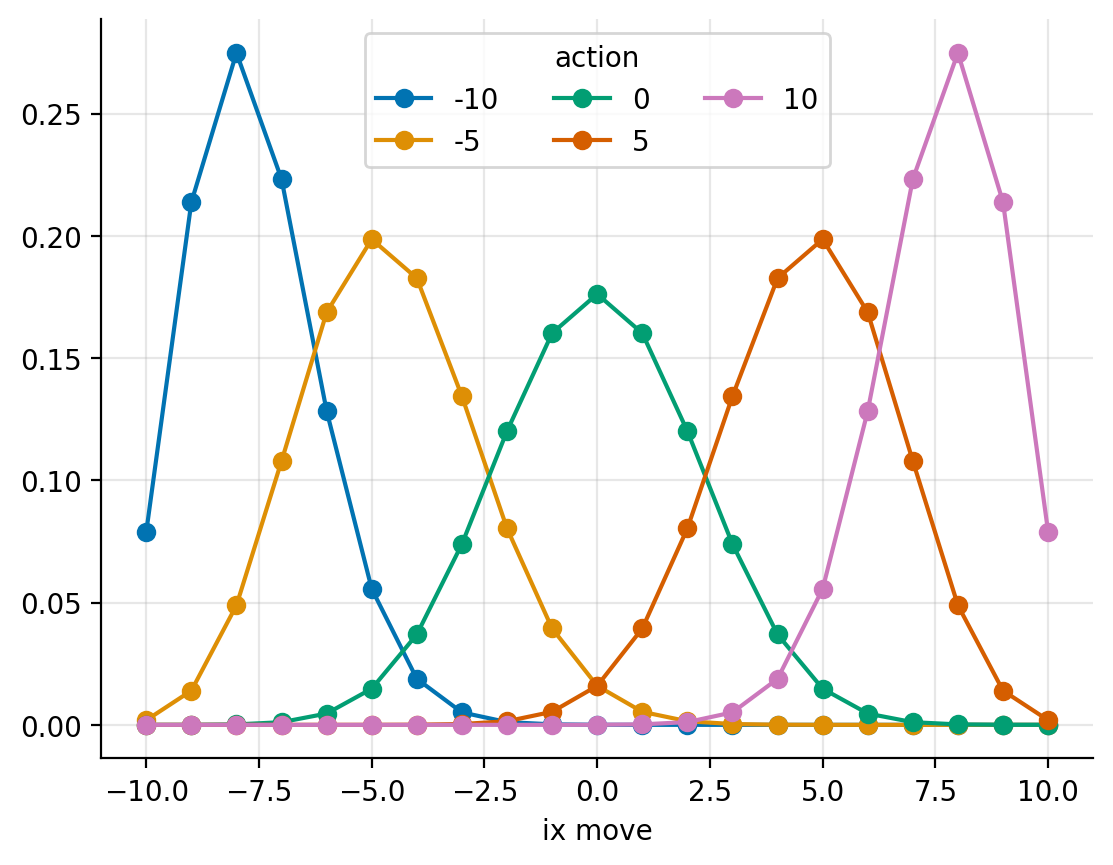

In [177]:
force_price = 10
price_impact = 0.2
prange = np.arange(0, 2 * force_price + 1)
ixrange = prange - force_price

for a in [-10, -5, 0, 5, 10]:
    dist = binom(2 * force_price, p=sigmoid(price_impact * a))
    probs = dist.pmf(prange)
    probs = probs / probs.sum()
    plt.plot(ixrange, probs, marker="o", label=a)
plt.grid(alpha=0.3)
plt.legend(title="action", ncol=3)
plt.xlabel("ix move")

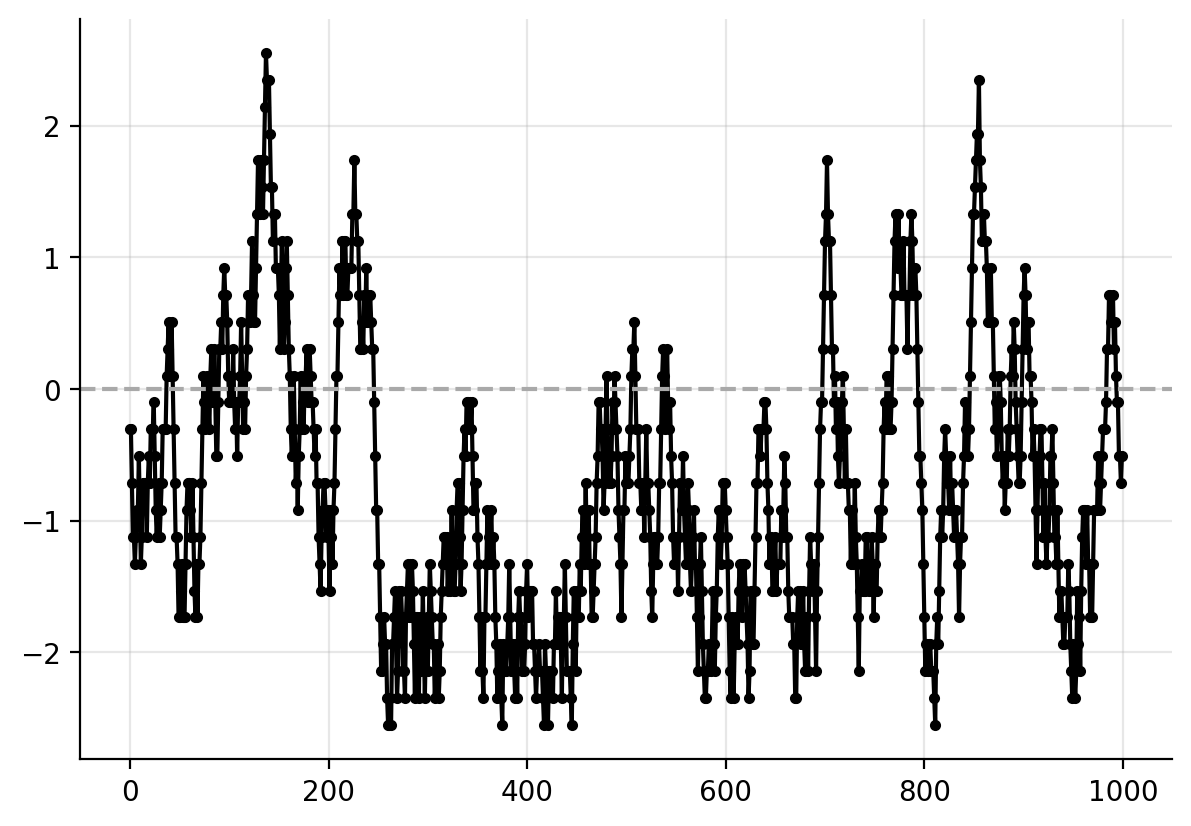

In [178]:
force_signal = 5
reversion_factor = 0.05

signal = bins_signal[25]
nsteps = 1000
signal_series = np.zeros(nsteps)

ix_next = 25
set_seed(314)
for n in range(nsteps):
    ix_next = signal_step_ix(ix_next, mid_ix, force_signal, reversion_factor, n_bins_signal)
    signal = bins_signal[ix_next]
    signal_series[n] = signal

fig, ax = plt.subplots(figsize=(6.4 * 1.1, 4.8))
plt.plot(signal_series, c="black", marker="o", markersize=3)
plt.axhline(y=0, c="darkgray", linestyle="--")
plt.grid(alpha=0.3)

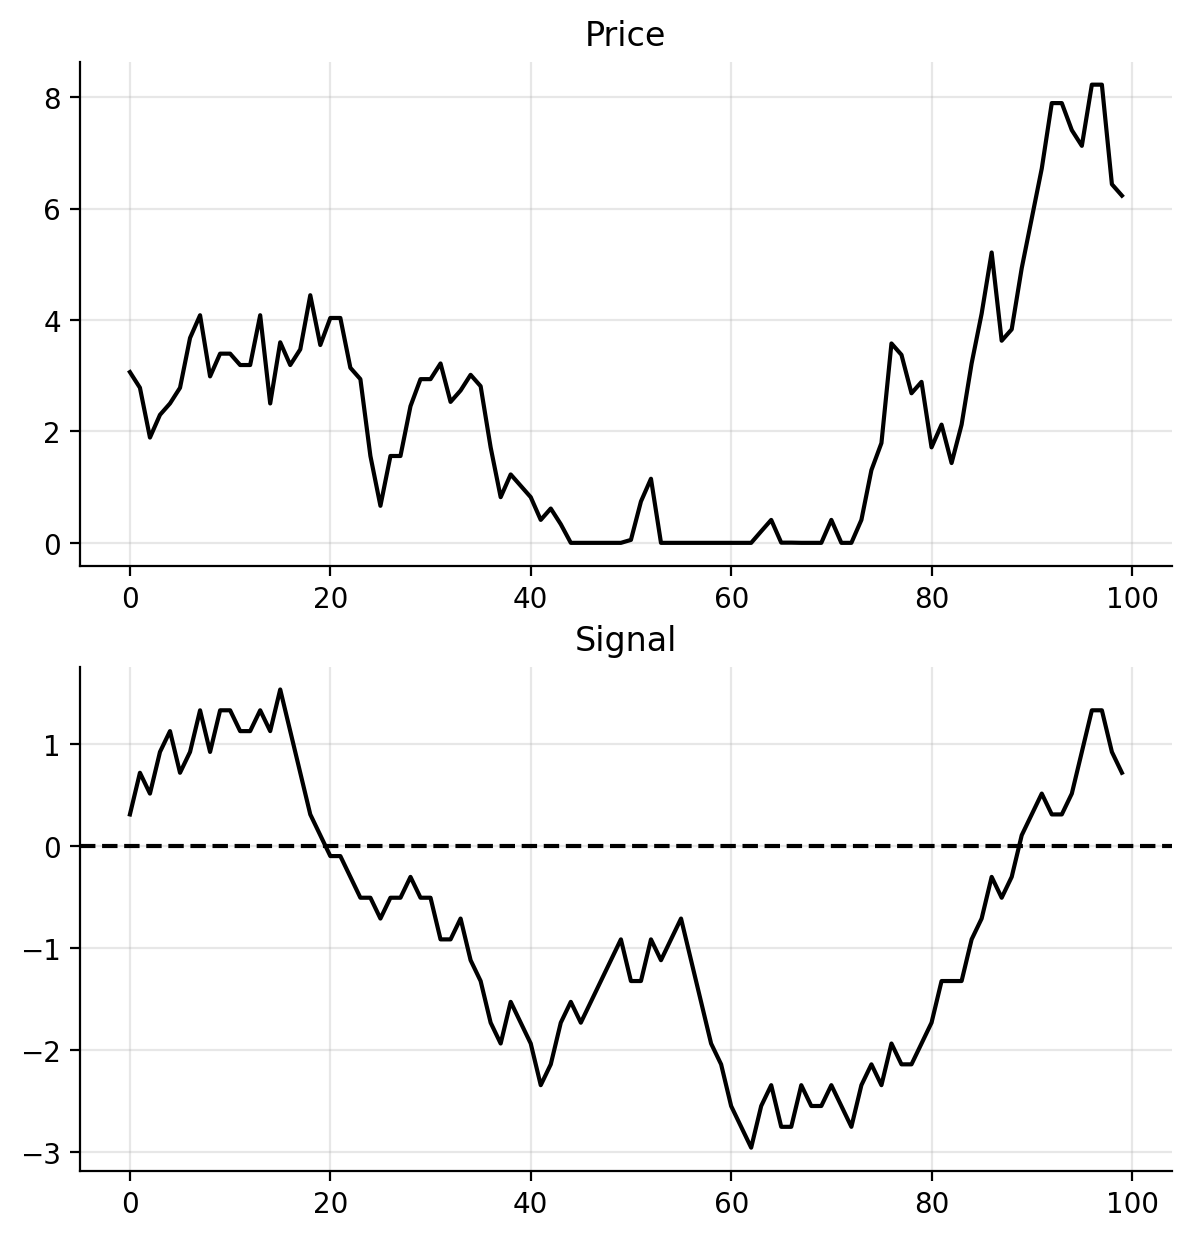

In [185]:
force_signal = 5 # equivalent to the standard deviation in the signal process
reversion_factor = 0.01

force_price = 2 # the equivalent to the standard deviation in the price process
price_impact = 0.01 # price impact on the action taken

signal = bins_signal[25]
nsteps = 100
signal_series = np.zeros(nsteps)
price_series = np.zeros(nsteps)

ix_signal = 25
ix_price = 5
action = 0
ixs_signal = np.zeros(nsteps)
ixs_price = np.zeros(nsteps)
for n in range(nsteps):
    ix_signal, ix_price = step_ix(
        ix_signal, ix_price, mid_ix,
        force_signal, reversion_factor, n_bins_signal,
        force_price, price_impact, n_bins_price
    )
    signal = bins_signal[ix_signal]
    price = lattice_price[ix_price, ix_signal]

    ixs_signal[n] = ix_signal
    ixs_price[n] = ix_price
    
    signal_series[n] = signal
    price_series[n] = price

fig, axs = plt.subplots(2, 1, figsize=(6.4 * 1.1, 4.8 * 1.5))
axs[0].plot(price_series, c="black")
axs[1].plot(signal_series, c="black")
axs[0].grid(alpha=0.3)
axs[1].grid(alpha=0.3)
axs[0].set_title("Price")
axs[1].set_title("Signal")
axs[1].axhline(y=0, c="black", linestyle="--")